### Is the model able to generate correct answers based on the context provided?


In [ ]:
%pip install numpy==1.26.4
%pip install pandas==1.3.3
%pip install seaborn==0.13



In [5]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import List, Optional
from langchain.chains.openai_tools import create_extraction_chain_pydantic
# from langchain_core.pydantic_v2 import BaseModel
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing import Literal, List
import pandas as pd
import numpy as np
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.language_models.chat_models import BaseChatModel
# import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import seaborn as sns
load_dotenv()


# - verify that llm is able to answer questions based on the context
# - veryfy that llm is able to generate a question based on the context
# - Is LLM able to automatically grade the students' answers?

# - some recommendation algorithms
# - pdf parser to text or markdown


True

Load SQUAD dataset

In [6]:
splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'validation': 'plain_text/validation-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/rajpurkar/squad/" + splits["validation"])

Define dataclasses for the questions

In [21]:
from langchain_core.messages.base import BaseMessage


question_answer_template = ChatPromptTemplate([
    ("system", "Based on the following text, answer user's question, make the answer short and preceise while sticking to the context: {context}"),
    ("user", "{question}")
    ]
)

answer_validation_template = ChatPromptTemplate([
    ("system", "As an teacher, you are asked to validate the answer to the following question on a scale from 1 (completely incorrect) to 5 (excelent) The question is: {question}. The context is: {context}. Example correct answers with grade 5: {correct_answer}. Is this answer correct?"),
    ("user", "{answer}"),
    ("system", "Remember to output only the grade of the answer from 1 to 5 ONLY!")
    ]
)
question_generation_template = ChatPromptTemplate([
    ("system", "Based on the context given by user, generate a question that can be answered using the mentioned text, remember that the question will be answered without looking at that context, so generate the question which will allow studnets faimiar with it to answer it correctly."),
    ("user", "{context}")
    ]
)
class OpenEndedQuestion(BaseModel):
    question: str = Field(..., description="The question text.")
    example_correct_answers: List[str] = Field(
        ..., 
        description="Examples of correct answers to the question."
    )
    context: str = Field(
        ..., 
        description="The context in which the question is being asked."
    )

    @classmethod
    def from_dataframe(cls, df: pd.DataFrame):
        questions = []
        for _, row in df.iterrows():
            # row['answers']['text'] is typically a list of correct answers in SQuAD
            questions.append(cls(
                question=row['question'],
                example_correct_answers=row['answers']['text'],
                context=row['context']
            ))
        return questions
    
    def generate_question_from_context(self, llm):
        messages = question_generation_template.format_messages(context=self.context)
        response = llm.invoke(messages)
        return response.content.strip()
    
    def generate_llm_response(self, llm: ChatOpenAI):
        messages = question_answer_template.format_messages(
            question=self.question, context=self.context
        )
        response = llm.invoke(messages)
        return response.content.strip()
    
    def validate_answer(self, answer: str, llm: ChatOpenAI):
        messages = answer_validation_template.format_messages(
            question=self.question,
            context=self.context,
            correct_answer=self.example_correct_answers,
            answer=answer
        )
        response = llm.invoke(messages).content.strip()

        # parse the numeric score
        try:
            grade = int(response)
            if grade < 1 or grade > 5:
                grade = 0
        except ValueError:
            grade = 0
        return grade


    

## Can LLM generate the answer to the question based on the context provided?

In [18]:


SAMPLE_SIZE = 2

sample_df = df.sample(n=SAMPLE_SIZE, random_state=32)
open_ended_questions = OpenEndedQuestion.from_dataframe(sample_df)

llm = ChatOpenAI(temperature=0, model="gpt-4o", api_key=os.getenv("OPEN_AI_KEY"))
llm_answers = []
for question in open_ended_questions:
    llm_answer = question.generate_llm_response(llm)
    llm_answers.append(llm_answer)



In [9]:
for question, answer in zip(open_ended_questions, llm_answers):
    print(f"Question: {question.question}")
    print(f"Generated Answer: {answer}")
    print(f"Correct Answers: {question.example_correct_answers}")
    print("\n")

Question: What does most of the HD material use as a standard?
Generated Answer: Most of the HD material uses the DVB-S2 standard.
Correct Answers: ['DVB-S2', 'DVB-S2', 'DVB-compliant MPEG-2']


Question: What physical quantities do not have direction?
Generated Answer: Physical quantities that do not have direction are called scalar quantities.
Correct Answers: ['denoted scalar quantities', 'scalar quantities', 'denoted scalar quantities', 'scalar quantities', 'scalar quantities']




## Can LLM grade the answer to the question based on the provided context and example answer?

LLM answer: Most of the HD material uses the DVB-S2 standard.
Example correct answers:  ['DVB-S2', 'DVB-S2', 'DVB-compliant MPEG-2']
LLM answer: Physical quantities that do not have direction are called scalar quantities.
Example correct answers:  ['denoted scalar quantities', 'scalar quantities', 'denoted scalar quantities', 'scalar quantities', 'scalar quantities']


(array([0., 0., 0., 0., 2.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <BarContainer object of 5 artists>)

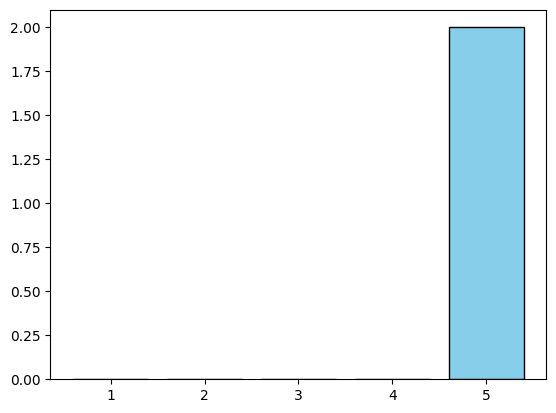

In [10]:
llm_results = []
for llm_answer, question in zip(llm_answers, open_ended_questions):
    grade = question.validate_answer(llm_answer, llm)
    llm_results.append(grade)
    print(f"LLM answer: {llm_answer}")
    print("Example correct answers: ", question.example_correct_answers)
# plot grade results on scale from 1 to 5
plt.hist(llm_results, bins=np.arange(1, 7) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
    

LLM Answer:  Most of the HD material uses the DVB-S2 standard.
Question:  What does most of the HD material use as a standard?
Correct Answer:  ['DVB-S2', 'DVB-S2', 'DVB-compliant MPEG-2']
LLM Grade:  5
LLM Answer:  Physical quantities that do not have direction are called scalar quantities.
Question:  What physical quantities do not have direction?
Correct Answer:  ['denoted scalar quantities', 'scalar quantities', 'denoted scalar quantities', 'scalar quantities', 'scalar quantities']
LLM Grade:  5


(array([0., 0., 0., 0., 2.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <BarContainer object of 5 artists>)

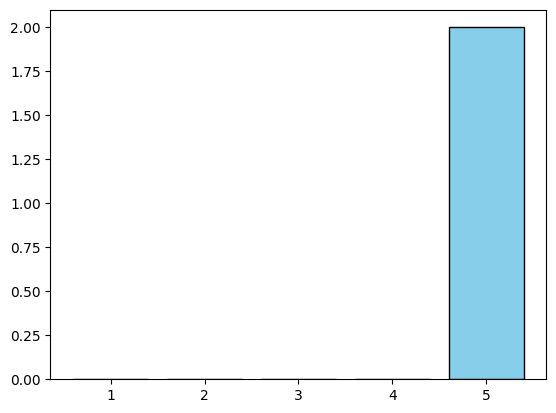

In [11]:
# Reshufffle the llm_answers and then grade them again to see if the grades will be lower
shuffled_llm_answers = np.random.permutation(llm_answers)
shuffled_llm_results = []
for llm_answer, question in zip(shuffled_llm_answers, open_ended_questions):
    print("LLM Answer: ", llm_answer)
    print("Question: ", question.question)
    print("Correct Answer: ", question.example_correct_answers)

    grade = question.validate_answer(llm_answer, llm)
    print("LLM Grade: ", grade)
    shuffled_llm_results.append(grade)
# plot grade results on scale from 1 to 5
plt.hist(shuffled_llm_results, bins=np.arange(1, 7) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')

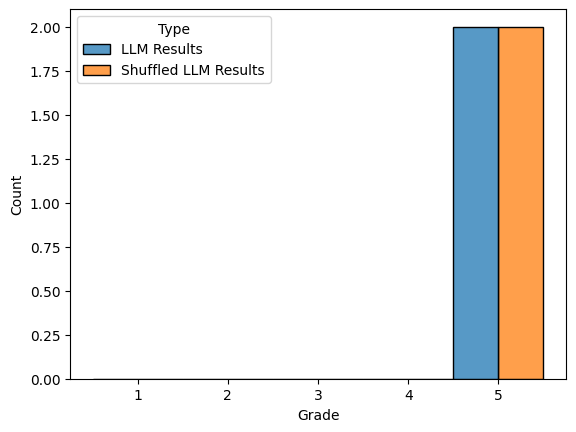

In [12]:

# Combine the results into a single DataFrame for seaborn
results_df = pd.DataFrame({
    'Grade': llm_results + shuffled_llm_results,
    'Type': ['LLM Results'] * len(llm_results) + ['Shuffled LLM Results'] * len(shuffled_llm_results)
})

# Plot using seaborn histplot with hue
sns.histplot(data=results_df, x='Grade', hue='Type', multiple='dodge', bins=np.arange(1, 7) - 0.5, edgecolor='black')
plt.show()

# Can LLM generate the question given some context?

In [22]:
generated_questions = []
for context_data in open_ended_questions:
    question = context_data.generate_question_from_context(llm)
    generated_questions.append(question)

# Display the generated questions along with their contexts
for context, question in zip(open_ended_questions, generated_questions):
    print(f"Context: {context}")
    print(f"Generated Question: {question}")
    print("\n")

Context: question='What does most of the HD material use as a standard?' example_correct_answers=['DVB-S2', 'DVB-S2', 'DVB-compliant MPEG-2'] context="BSkyB's standard definition broadcasts are in DVB-compliant MPEG-2, with the Sky Movies and Sky Box Office channels including optional Dolby Digital soundtracks for recent films, although these are only accessible with a Sky+ box. Sky+ HD material is broadcast using MPEG-4 and most of the HD material uses the DVB-S2 standard. Interactive services and 7-day EPG use the proprietary OpenTV system, with set-top boxes including modems for a return path. Sky News, amongst other channels, provides a pseudo-video on demand interactive service by broadcasting looping video streams."
Generated Question: What technology does BSkyB use for broadcasting its standard definition and HD material, and what system is used for interactive services and the electronic program guide?


Context: question='What physical quantities do not have direction?' exampl

# Example of full flow in the pipeline for open ended question answering

In [23]:
ba_description = OpenEndedQuestion(question="", example_correct_answers=[], context="The Barabási–Albert (BA) model is an algorithm for generating random scale-free networks using a preferential attachment mechanism. Several natural and human-made systems, including the Internet, the World Wide Web, citation networks, and some social networks are thought to be approximately scale-free and certainly contain few nodes (called hubs) with unusually high degree as compared to the other nodes of the network. The BA model tries to explain the existence of such nodes in real networks. The algorithm is named for its inventors Albert-László Barabási and Réka Albert.")

In [26]:
llm_question = ba_description.generate_question_from_context(llm)
llm_question

'What is the Barabási–Albert model, and what types of networks does it aim to explain?'

In [28]:
ba_description.question = llm_question
llm_answer = ba_description.generate_llm_response(llm)
llm_answer

'The Barabási–Albert model is an algorithm for generating random scale-free networks using a preferential attachment mechanism. It aims to explain networks like the Internet, the World Wide Web, citation networks, and some social networks, which contain hubs with unusually high degrees.'

In [29]:
ba_description.example_correct_answers = ["The Barabási–Albert (BA) model is an algorithm for generating random scale-free networks using a preferential attachment mechanism.", "The Barabási–Albert model is a way to build networks with a “rich-get-richer” link structure, producing scale-free networks that match real systems like the Web, social media, and citation networks."]
grade = ba_description.validate_answer(llm_answer, llm)
grade


5

In [ ]:
#TODO generate multiple choice questions